# Property Price Prediction (KL)

I have been given a set of data with SPA transaction details of KL properties.

I was asked an open question: **'How Data Science can be applied with this kind of data?'**

While trying to figure out an answer, I decided to make this as my EDS assignment. By looking at the data, I guess the most straightforward objective is to do price prediction. Classification of property type may not be as meaningful.

Dataset is considered simple. I should have enriched it by other sources for better prediction accuracy. However I have decided to proceed with just this given data as I have resource challenges to explore more.

As a new skillset development, my personal agenda is to learn some Machine Learning methods for value extraction with data. (I did not have hands-on Machine Learning experience before joining EDS.) Of course, partly is to fulfill course requirement as well!

In [117]:
# The list of libraries for this assignment

import pandas as pd
import numpy as np
from numpy import linspace
import re
import seaborn as sns; sns.set()
import matplotlib.pylab as plt
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

%matplotlib inline

In [118]:
# Use pandas to import data

df = pd.read_csv('D:/Temp\PVT/kl-all.csv')

In [119]:
# After data import into DataFrame, take a quick view

print('df.shape: ',df.shape)
df.head()

df.shape:  (46822, 10)


,web-scraper-order,web-scraper-start-url,SPA Date,Address,Building Type,Tenure,Rooms,Lot Size,Price Psf,Price
0,1515790233-38567,https://www.brickz.my/transactions/residential...,14/08/2017,"A-14-7, JALAN 5/125",CONDOMINIUM,LEASEHOLD,2,"1,001 ft²",462,"462,000"
1,1515792848-48441,https://www.brickz.my/transactions/residential...,03/06/2016,"B-11-5, LORONG ANG SENG 2",APARTMENT,FREEHOLD,3,926 ft²,540,"500,000"
2,1515793769-51562,https://www.brickz.my/transactions/residential...,21/04/2016,"A-11-7, JALAN 1/62B",CONDOMINIUM,FREEHOLD,3,"1,076 ft²",437,"470,000"
3,1515782994-13216,https://www.brickz.my/transactions/residential...,29/07/2008,"C-5-12, JALAN MELATI UTAMA",CONDOMINIUM,FREEHOLD,3,"1,270 ft²",197,"250,000"
4,1515786690-26968,https://www.brickz.my/transactions/residential...,14/11/2013,"B2-38-1 (P: B2-38-1), JALAN KIARA",CONDOMINIUM,FREEHOLD,4,"2,539 ft²",803,"2,040,000"


## Data Exploration

1. Remove uncessary columns
2. Check for null value & empty cell
3. Remove non-numerical characters in numerical columns
4. Convert 'SPA Date' to datetime
5. Drop collinear column e.g. 'Price Psf'
6. Extract 'State', 'Area', 'Property Name'

In [120]:
# 'web-scrapper-order' & 'Address' not needed
# Drop from df

print('df.shape (original): ',df.shape)
print('web-scrapper-order column unique count:',df['web-scraper-order'].nunique())

# Drop unnecessary columns
df.drop(['web-scraper-order','Address'],inplace=True,axis=1)
print('df.shape (after drop): ',df.shape)
df.head()

df.shape (original):  (46822, 10)
web-scrapper-order column unique count: 46822
df.shape (after drop):  (46822, 8)


,web-scraper-start-url,SPA Date,Building Type,Tenure,Rooms,Lot Size,Price Psf,Price
0,https://www.brickz.my/transactions/residential...,14/08/2017,CONDOMINIUM,LEASEHOLD,2,"1,001 ft²",462,"462,000"
1,https://www.brickz.my/transactions/residential...,03/06/2016,APARTMENT,FREEHOLD,3,926 ft²,540,"500,000"
2,https://www.brickz.my/transactions/residential...,21/04/2016,CONDOMINIUM,FREEHOLD,3,"1,076 ft²",437,"470,000"
3,https://www.brickz.my/transactions/residential...,29/07/2008,CONDOMINIUM,FREEHOLD,3,"1,270 ft²",197,"250,000"
4,https://www.brickz.my/transactions/residential...,14/11/2013,CONDOMINIUM,FREEHOLD,4,"2,539 ft²",803,"2,040,000"


In [121]:
# check for null value or empty cell

print('isnull():',df.isnull().any().any())
print('')
print(df.applymap(lambda x: x == '').any())
print('')
for x in np.arange(df.shape[1]):
    if df.iloc[:,x].astype('O').str.contains('null').any():
        print(df.columns[x],'column contains null')

isnull(): False

web-scraper-start-url    False
SPA Date                 False
Building Type            False
Tenure                   False
Rooms                    False
Lot Size                 False
Price Psf                False
Price                    False
dtype: bool

Lot Size column contains null


In [122]:
# Replace 'null' with '0'
df['Lot Size'].replace('null','0',inplace=True)

# Add 'Size' numeric column and drop 'Lot Size' 
df['Size'] = pd.to_numeric(df['Lot Size'].str.replace(r'\D+', ''), errors='coerce')
df.drop('Lot Size',inplace=True,axis=1)

# Convert 'Price' & 'Price Psf' into numerics, remove all non-numerical characters (ft^2, ',')
df['Price'] = pd.to_numeric(df['Price'].str.replace(r'\D+', ''), errors='coerce')
df['Price Psf'] = pd.to_numeric(df['Price Psf'].str.replace(r'\D+', ''), errors='coerce')

df.head()

,web-scraper-start-url,SPA Date,Building Type,Tenure,Rooms,Price Psf,Price,Size
0,https://www.brickz.my/transactions/residential...,14/08/2017,CONDOMINIUM,LEASEHOLD,2,462,462000,1001
1,https://www.brickz.my/transactions/residential...,03/06/2016,APARTMENT,FREEHOLD,3,540,500000,926
2,https://www.brickz.my/transactions/residential...,21/04/2016,CONDOMINIUM,FREEHOLD,3,437,470000,1076
3,https://www.brickz.my/transactions/residential...,29/07/2008,CONDOMINIUM,FREEHOLD,3,197,250000,1270
4,https://www.brickz.my/transactions/residential...,14/11/2013,CONDOMINIUM,FREEHOLD,4,803,2040000,2539


In [123]:
# Calculate Size using 'Price' and 'Price Psf'

print('Size = 0, count (before):',sum(df.iloc[:,-1]==0))
mask = df['Size']==0
df['Size'][mask] = df['Price'][mask] / df['Price Psf'][mask]
print('Size = 0, count (after):',sum(df.iloc[:,-1]==0))

df.drop('Price Psf',inplace=True,axis=1)

Size = 0, count (before): 8511
Size = 0, count (after): 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46822 entries, 0 to 46821
Data columns (total 7 columns):
web-scraper-start-url    46822 non-null object
SPA Date                 46822 non-null object
Building Type            46822 non-null object
Tenure                   46822 non-null object
Rooms                    46822 non-null int64
Price                    46822 non-null int64
Size                     46822 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.5+ MB


In [125]:
# Add 'Date' column in datetime, drop 'SPA Date' 

df['Date'] = pd.to_datetime(df['SPA Date'], format='%d/%m/%Y')
df.drop('SPA Date',inplace=True,axis=1)

>2014 data size: (22915, 7)


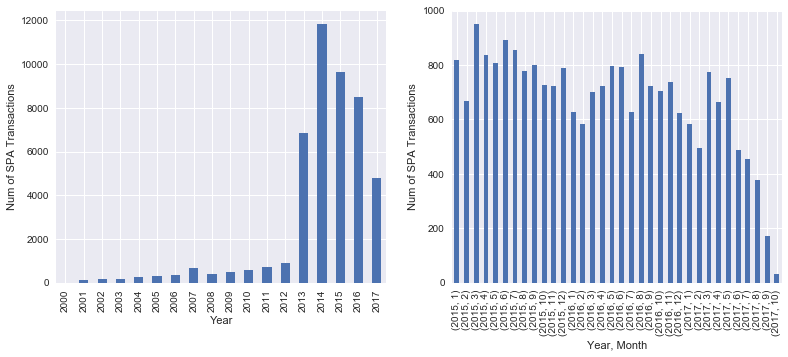

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# Plot number of transactions grouped by Year
df_grp = df.groupby(df.Date.dt.year).size()
f = df_grp.plot(kind='bar',ax=axes[0])
f.set_xlabel('Year')
f.set_ylabel('Num of SPA Transactions')

# Suspect data was incomplete <2013
# Only take >2014, use recent years data for price prediction
df = df[df.Date.dt.year>2014]
print('>2014 data size:',df.shape)

# Plot number of transactions grouped by Year-Month
df_grp = df.groupby([df.Date.dt.year,df.Date.dt.month]).size()
f = df_grp.plot(kind='bar',ax=axes[1])
f.set_xlabel('Year, Month')
f.set_ylabel('Num of SPA Transactions')

In [127]:
df['Year'] = df.Date.dt.year
df.drop(['Date'],inplace=True,axis=1)
print(df.shape)
df.head(3)

(22915, 7)


,web-scraper-start-url,Building Type,Tenure,Rooms,Price,Size,Year
0,https://www.brickz.my/transactions/residential...,CONDOMINIUM,LEASEHOLD,2,462000,1001.0,2017
1,https://www.brickz.my/transactions/residential...,APARTMENT,FREEHOLD,3,500000,926.0,2016
2,https://www.brickz.my/transactions/residential...,CONDOMINIUM,FREEHOLD,3,470000,1076.0,2016


In [128]:
# Count number of transactions by Property Type

df['Building Type'].value_counts()

CONDOMINIUM                     8835
SERVICE RESIDENCE               3354
FLAT                            3136
TERRACE HOUSE - INTERMEDIATE    2898
APARTMENT                       2802
BUNGALOW                         561
SEMI-D                           396
TERRACE HOUSE - CORNER LOT       279
TOWN HOUSE                       259
TERRACE HOUSE - END LOT          201
CLUSTER HOUSE - INTERMEDIATE     160
CLUSTER HOUSE                     15
CLUSTER HOUSE - CORNER LOT        12
CLUSTER HOUSE - END LOT            7
Name: Building Type, dtype: int64

In [129]:
# Not sure what is CLUSTER HOUSE, I decided to regroup all CLUSTER HOUSE in single type since the count is small

#df['Building Type'][df['Building Type'].str.contains('TERRACE')] = 'TERRACE'
df['Building Type'][df['Building Type'].str.contains('CLUSTER')] = 'CLUSTER HOUSE'
df['Building Type'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


CONDOMINIUM                     8835
SERVICE RESIDENCE               3354
FLAT                            3136
TERRACE HOUSE - INTERMEDIATE    2898
APARTMENT                       2802
BUNGALOW                         561
SEMI-D                           396
TERRACE HOUSE - CORNER LOT       279
TOWN HOUSE                       259
TERRACE HOUSE - END LOT          201
CLUSTER HOUSE                    194
Name: Building Type, dtype: int64

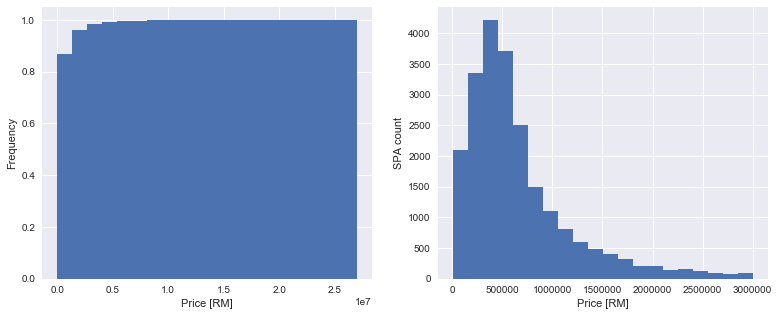

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# Examine the CDF of Price
df['Price'].plot.hist(bins=20, cumulative=True, normed=True, ax = axes[0])
axes[0].set_xlabel('Price [RM]')

# Can see around 95% of transactions below 3mil
# Now zoom in to <3mil
df['Price'].plot.hist(bins=20, range=(5000,3000000), ax = axes[1])
axes[1].set_xlabel('Price [RM]')
axes[1].set_ylabel('SPA count')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


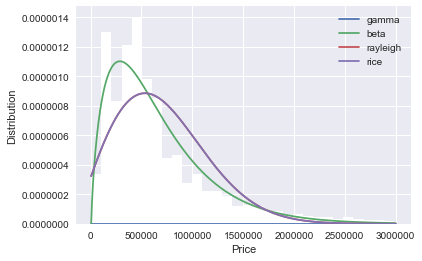

In [131]:
# I tried to fit a distribution to Price
# Seemed like beta is good fit

mask = (df['Price']<3000000) & (df['Price']>5000)

y = list(df['Price'][mask])
plt.hist(y, bins=30, color='w',normed=1)

x = linspace(5000,3000000,1000)
dist_names = ['gamma', 'beta', 'rayleigh', 'rice']
for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) 
    plt.plot(x,pdf_fitted, label=dist_name)

plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Distribution')
plt.show()

In [25]:
df['Price'].skew()

5.6271037566119784

In [26]:
price_log = np.log(df['Price'])
price_log.skew()

0.081460024311092685

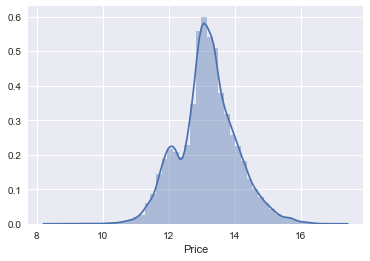

In [27]:
sns.distplot(price_log)

In [132]:
df.head()

,web-scraper-start-url,Building Type,Tenure,Rooms,Price,Size,Year
0,https://www.brickz.my/transactions/residential...,CONDOMINIUM,LEASEHOLD,2,462000,1001.000000,2017
1,https://www.brickz.my/transactions/residential...,APARTMENT,FREEHOLD,3,500000,926.000000,2016
2,https://www.brickz.my/transactions/residential...,CONDOMINIUM,FREEHOLD,3,470000,1076.000000,2016
6,https://www.brickz.my/transactions/residential...,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,3,900000,1251.738526,2016
8,https://www.brickz.my/transactions/residential...,CONDOMINIUM,FREEHOLD,4,9900000,3218.000000,2017


In [133]:
# I suspected the 'web-scraper-start-url' column has common prefix
# E.g. https://www.brickz.my/transactions/residential/kuala-lumpur/kl-city-centre/setia-sky-residence/non-landed/page/4/?range=2000+Dec-

# check if it's common URL 'https://www.brickz.my/transactions/residential/kuala-lumpur/'
print('df.shape:',df.shape)
df['Temp'] = df['web-scraper-start-url'].str.extract(r'(https://www.brickz.my/transactions/residential/kuala-lumpur/)',expand=False)
print(df['Temp'].value_counts())

# Only extract 'State/Area/Property_Name' into 'Temp' column
df['Temp'] = df['web-scraper-start-url'].str.extract(r'residential\/(([a-z0-9\-]+)\/([a-z0-9\-]+)\/([a-z0-9\-]+))\/',expand=False)
df.head()

df.shape: (22915, 7)
https://www.brickz.my/transactions/residential/kuala-lumpur/    22915
Name: Temp, dtype: int64


,web-scraper-start-url,Building Type,Tenure,Rooms,Price,Size,Year,Temp
0,https://www.brickz.my/transactions/residential...,CONDOMINIUM,LEASEHOLD,2,462000,1001.000000,2017,kuala-lumpur/desa-petaling/amadesa
1,https://www.brickz.my/transactions/residential...,APARTMENT,FREEHOLD,3,500000,926.000000,2016,kuala-lumpur/brickfields/menara-pelangi
2,https://www.brickz.my/transactions/residential...,CONDOMINIUM,FREEHOLD,3,470000,1076.000000,2016,kuala-lumpur/bandar-menjalara/menara-menjalara
6,https://www.brickz.my/transactions/residential...,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,3,900000,1251.738526,2016,kuala-lumpur/salak-south/salak-south-garden
8,https://www.brickz.my/transactions/residential...,CONDOMINIUM,FREEHOLD,4,9900000,3218.000000,2017,kuala-lumpur/kl-city-centre/the-binjai-on-the-...


In [134]:
# Create colummns 'Area' and 'Prop_Name'
# Since this dataset is KL ones, State is always kuala-lumpur here
# Drop 'web-scraper-start-url' & 'Temp' columns after operations

#df['State'] = df['Temp'].str.extract(r'([\w-]+)',expand=False)
df['Area'] = df['Temp'].str.extract(r'[\w-]+\/([\w-]+)',expand=False)
df['Prop_Name'] = df['Temp'].str.extract(r'[\w-]+\/[\w-]+\/([\w-]+)',expand=False)
df.drop(['web-scraper-start-url','Temp'],inplace=True,axis=1)
print('df.shape:',df.shape)
df.head()

df.shape: (22915, 8)


,Building Type,Tenure,Rooms,Price,Size,Year,Area,Prop_Name
0,CONDOMINIUM,LEASEHOLD,2,462000,1001.000000,2017,desa-petaling,amadesa
1,APARTMENT,FREEHOLD,3,500000,926.000000,2016,brickfields,menara-pelangi
2,CONDOMINIUM,FREEHOLD,3,470000,1076.000000,2016,bandar-menjalara,menara-menjalara
6,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,3,900000,1251.738526,2016,salak-south,salak-south-garden
8,CONDOMINIUM,FREEHOLD,4,9900000,3218.000000,2017,kl-city-centre,the-binjai-on-the-park


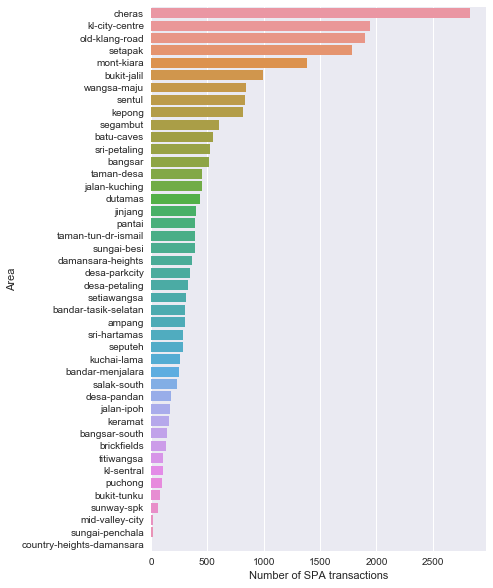

In [135]:
# Plot number of transactions grouped by Area

Area1 = df['Area'].value_counts()
f, ax = plt.subplots(figsize=(6, 10))
sns.set(style='darkgrid')
sns.barplot(y=Area1.index,x=list(Area1.data))
ax.set(ylabel="Area", xlabel="Number of SPA transactions")
sns.despine(left=True, bottom=True)

(0, 3000000)

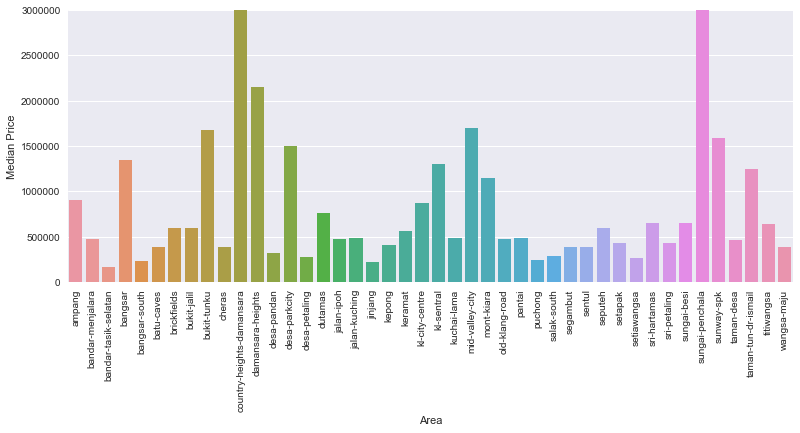

In [136]:
# Plot median price per Area

Area2 = df.pivot_table(index='Area',values='Price',aggfunc=np.median)
Area2.reset_index(inplace=True)

f, ax = plt.subplots(figsize=(13, 5))
sns.set(style='darkgrid')
sns.barplot(x=Area2.Area,y=list(Area2.Price))
ax.set(xlabel="Area", ylabel="Median Price")
sns.despine(left=True, bottom=True)
plt.xticks(rotation = 90)
plt.ylim(0,3000000)

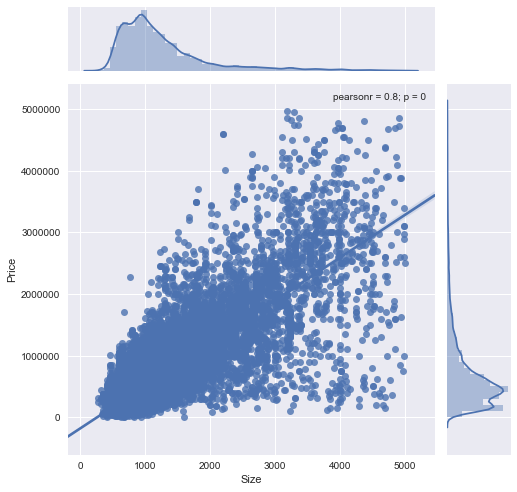

In [137]:
# Scatter plot and distributions of Size vs Price
# Zoom in to <5mil, and <5000 sqft

mask = ((df['Price']>5000) & (df['Price']<5000000)) & (df['Size']<5000)
sns.jointplot(y="Price", x="Size", data=df[mask], kind='reg', size=7)
#sns.despine(bottom=True)
#plt.tight_layout(h_pad=3)

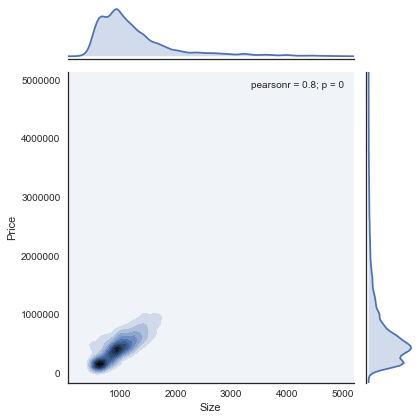

In [138]:
# Density plot and distributions of Size vs Price
# Zoom in to <5mil, and <5000 sqft

mask = ((df['Price']>5000) & (df['Price']<5000000)) & (df['Size']<5000)

with sns.axes_style("white"):
    g = sns.jointplot(y="Price", x="Size", data=df[mask], kind="kde")   
plt.tight_layout()

# Observe the concentration around <1.5mil and <2000 sqft

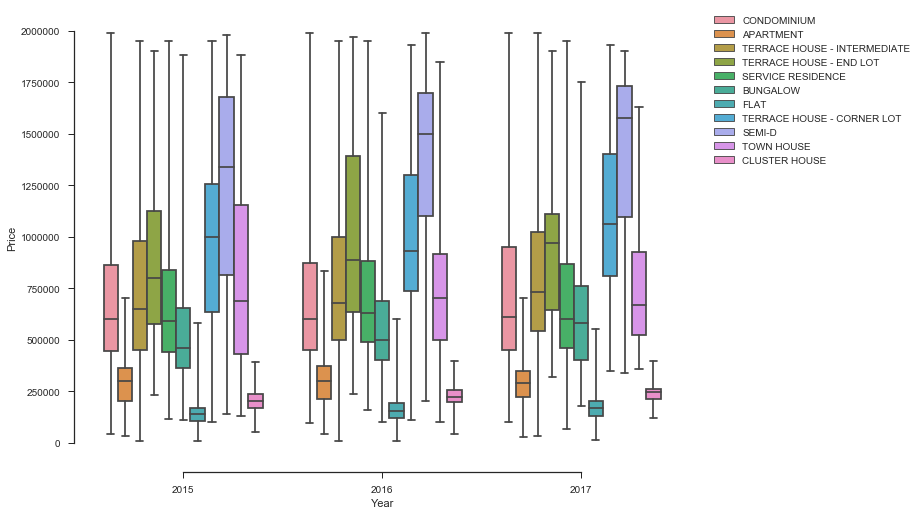

In [139]:
# Boxplot by Property Type and Year

mask = ((df['Price']>5000) & (df['Price']<2000000)) & (df['Size']<5000)

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 8.27)
sns.boxplot(x='Year', y='Price', hue="Building Type", 
            data=df[mask], whis=np.inf, ax=ax)
sns.despine(offset=10, trim=True)
ax.set(xlabel="Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Can observe no obvious large appreciation of property prices over 3 yrs 

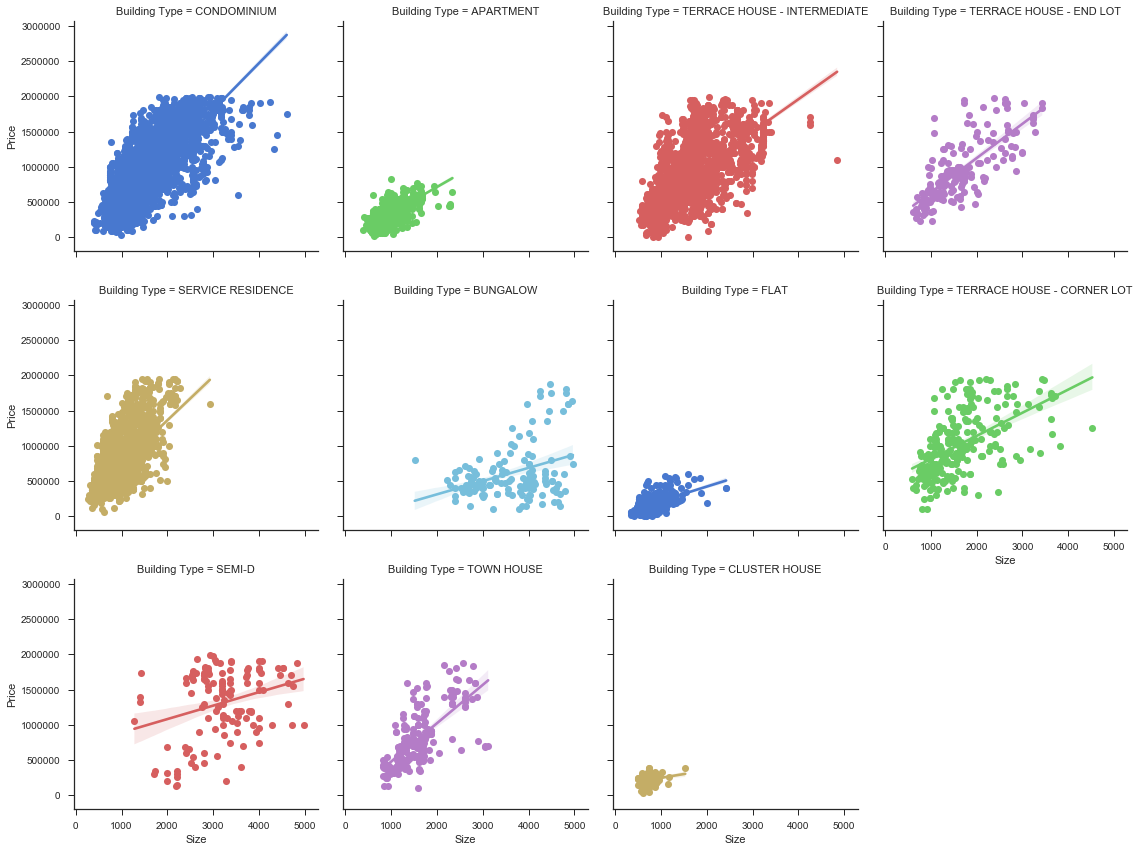

In [140]:
# Individual scatter plot Price-Size for each Building Type

mask = ((df['Price']>5000) & (df['Price']<2000000)) & (df['Size']<5000)

sns.lmplot(x="Size", y="Price", col="Building Type", hue="Building Type", data=df[mask],
           col_wrap=4, ci=90, palette="muted", size=4, truncate=True,
           scatter_kws={"s": 50, "alpha": 1})

# If model fit to global data, may have low performance
# Suggest to zoom in to individual area and property type

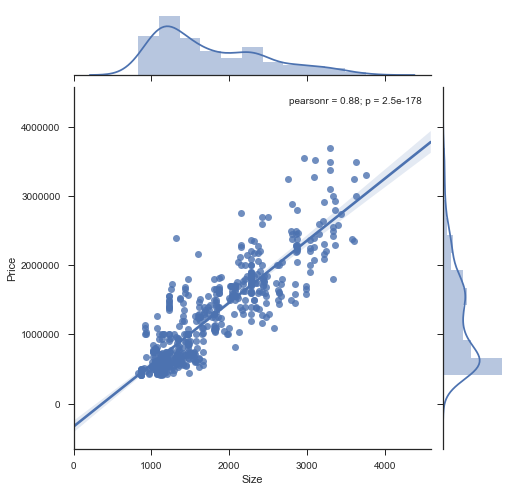

In [141]:
# Now zoom in to Area and Building Type
# LR is sensitive to outliers, suggest to restrict data to 5th - 95th percentile

mask = (df['Area']=='kl-city-centre') & (df['Building Type']=='CONDOMINIUM')
#mask = (df['Area']=='kl-city-centre') & (df['Building Type']=='SERVICE RESIDENCE')

p1 = np.percentile(df['Price'][mask],5)
p2 = np.percentile(df['Price'][mask],95)
s1 = np.percentile(df['Size'][mask],5)
s2 = np.percentile(df['Size'][mask],95)
df_temp = df[mask]
mask = (df_temp['Price']>p1) & (df_temp['Price']<p2)
df_temp = df_temp[mask]
mask = (df_temp['Size']>s1) & (df_temp['Size']<s2)
sns.jointplot(y="Price", x="Size", data=df_temp[mask], kind='reg', size=7)

# Model is expected to perform better in this case

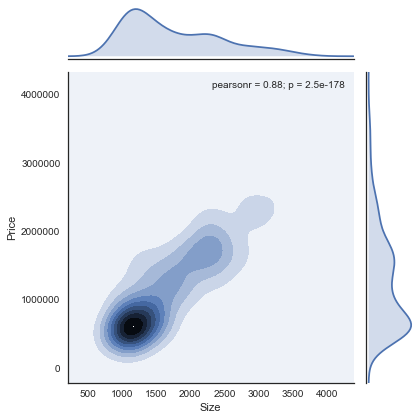

In [142]:
with sns.axes_style("white"):
    g = sns.jointplot(y="Price", x="Size", data=df_temp[mask], kind="kde")   
plt.tight_layout()

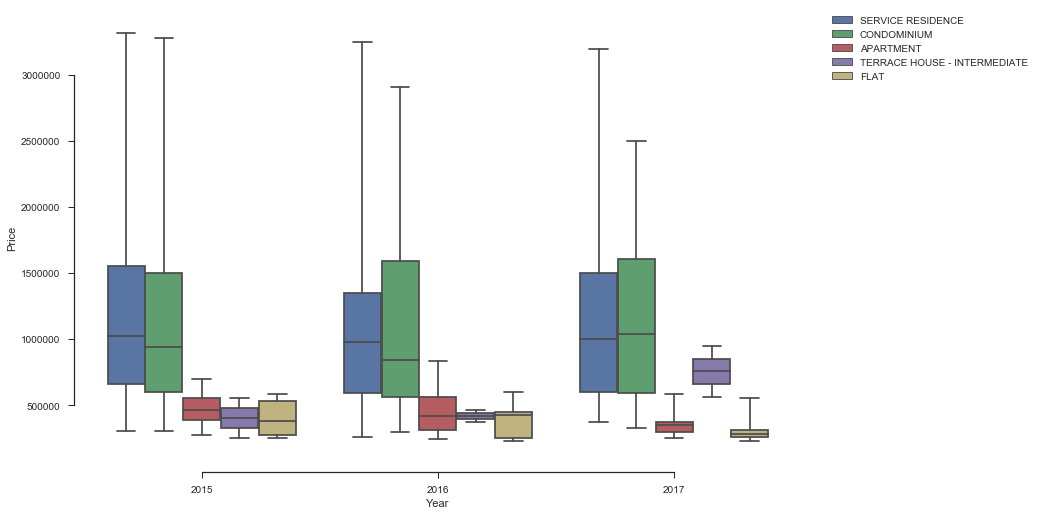

In [143]:
mask = (df['Area']=='kl-city-centre')
p1 = np.percentile(df['Price'][mask],5)
p2 = np.percentile(df['Price'][mask],95)
s1 = np.percentile(df['Size'][mask],5)
s2 = np.percentile(df['Size'][mask],95)
df_temp = df[mask]
mask = (df_temp['Price']>p1) & (df_temp['Price']<p2)
df_temp = df_temp[mask]
mask = (df_temp['Size']>s1) & (df_temp['Size']<s2)

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.boxplot(x='Year', y='Price', hue="Building Type", data=df_temp[mask], whis=np.inf, ax=ax)#.set_title('Area='+X.index[ind])
sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

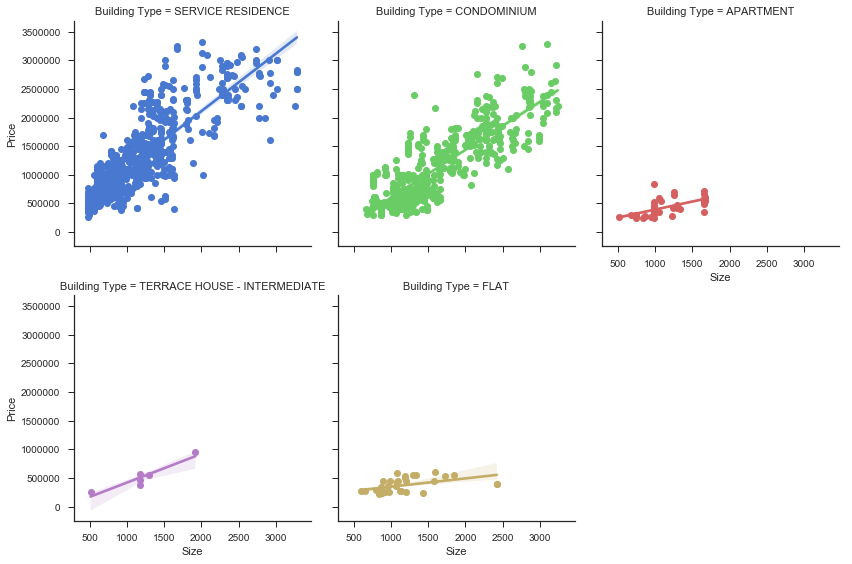

In [144]:
# Zoom in to one Area, plot Price-Size scatterplot by Building Type

sns.lmplot(x="Size", y="Price", col="Building Type", hue="Building Type", data=df_temp[mask],
           col_wrap=3, ci=90, palette="muted", size=4, truncate=True,
           scatter_kws={"s": 50, "alpha": 1})

In [145]:
# Describe categorical variables

df.select_dtypes(exclude=[np.number]).describe()

,Building Type,Tenure,Area,Prop_Name
count,22915,22915,22915,22915
unique,11,2,44,1196
top,CONDOMINIUM,FREEHOLD,cheras,oug-parklane
freq,8835,14253,2829,330


In [146]:
# Encode categorical variables

le = LabelEncoder()
mask = ((df['Price']>5000) & (df['Price']<1500000)) & (df['Size']<3000)
df_le = df[['Building Type','Tenure','Area','Prop_Name']][mask].apply(le.fit_transform)
df_le[['Rooms','Price','Size','Year']] = df[['Rooms','Price','Size','Year']][mask]
print(df_le.shape)
df_le.head()

(20046, 8)


,Building Type,Tenure,Area,Prop_Name,Rooms,Price,Size,Year
0,3,1,13,31,2,462000,1001.000000,2017
1,0,0,6,454,3,500000,926.000000,2016
2,3,0,1,451,3,470000,1076.000000,2016
6,9,0,28,644,3,900000,1251.738526,2016
10,8,0,42,1025,3,800000,1250.000000,2015


Price            1.000000
Size             0.719816
Building Type    0.302824
Rooms            0.163088
Year             0.050095
Area             0.004404
Prop_Name       -0.023084
Tenure          -0.369455
Name: Price, dtype: float64

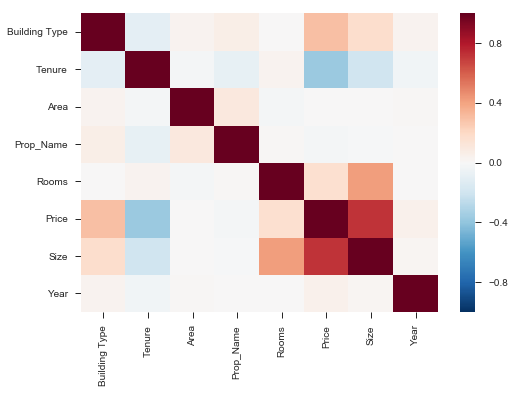

In [147]:
# Correlation of data set

corr = df_le.corr()
sns.heatmap(corr)
plt.xticks(rotation = 90)
corr['Price'].sort_values(ascending=False)

# Can see data has no linearity
# Price has stronger relationship with Size and Building Type

In [148]:
# Zoom in to one Area and 5th - 95th percentile in Price and Size
# Check correlation again

mask = (df['Area']=='old-klang-road')
p1 = np.percentile(df['Price'][mask],5)
p2 = np.percentile(df['Price'][mask],95)
s1 = np.percentile(df['Size'][mask],5)
s2 = np.percentile(df['Size'][mask],95)
df_temp = df[mask]
mask = (df_temp['Price']>p1) & (df_temp['Price']<p2)
df_temp = df_temp[mask]
mask = (df_temp['Size']>s1) & (df_temp['Size']<s2)

df_le = df_temp[['Building Type','Tenure','Prop_Name']][mask].apply(le.fit_transform)
df_le[['Rooms','Price','Size','Year']] = df_temp[['Rooms','Price','Size','Year']][mask]
print(df_le.shape)
df_le.head()

(1637, 7)


,Building Type,Tenure,Prop_Name,Rooms,Price,Size,Year
28,1,0,44,4,950000,1524.0,2015
67,1,0,0,3,650000,1485.0,2016
81,1,0,44,4,770000,1523.0,2016
191,1,0,0,3,667350,1485.0,2016
220,1,0,0,3,593200,1485.0,2016


Price            1.000000
Size             0.839076
Rooms            0.253097
Building Type    0.126412
Year             0.073829
Prop_Name       -0.035708
Tenure          -0.243894
Name: Price, dtype: float64

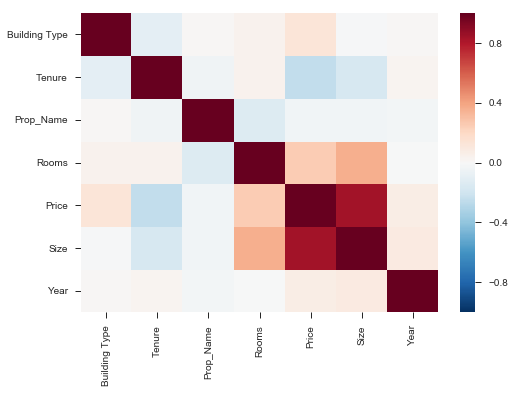

In [150]:
corr = df_le.corr()
sns.heatmap(corr)
plt.xticks(rotation = 90)
corr['Price'].sort_values(ascending=False)

## Model Training & Evaluation

### Models considered:
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. RandomForest Regressor

### Notes:
- Target is to predict Price
- Data set used in training ranging from 1-6 features
- Mandatory feature is Size
- First, use data with all Area and Property Type
- Next, zoom in to specific Area and Property Type

In [152]:
# Perform LR with x = Size, y = Price
# Use all Area & all Building Type

x = df['Size']
y = df['Price']
X = x[:, np.newaxis]
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = LinearRegression()
param = {'fit_intercept' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:' ,metrics.r2_score(y_test, grid.predict(X_test)))

(22915, 1) (22915,)
(17186, 1) (17186,) (5729, 1) (5729,)
Score: 0.61746531646


In [54]:
model.fit(X_train, np.log(y_train))
#metrics.r2_score(np.log(y_test), model.predict(X_test))
print('Score (log):', metrics.r2_score(y_test, np.exp(model.predict(X_test))))

Score (log): -6.95323090577e+226


In [153]:
# Perform LR with 5 features: Size, Building Types, Area, Tenure, Prop_Name 

# Encode categorial features
X = df[['Building Type','Area','Tenure','Prop_Name']].apply(le.fit_transform)
X['Size'] = df['Size']
y = df['Price']
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = LinearRegression()
param = {'fit_intercept' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:' ,metrics.r2_score(y_test, grid.predict(X_test)))

# obtained little improvement in score

(22915, 5) (22915,)
(17186, 5) (17186,) (5729, 5) (5729,)
Score: 0.652712595115


In [154]:
# Perform LR with 6 features: Size, Building Types, Area, Tenure, Prop_Name, Rooms

# Encode categorial features
X = df[['Building Type','Area','Tenure','Prop_Name']].apply(le.fit_transform)
X[['Size','Rooms']] = df[['Size','Rooms']]
y = df['Price']
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = LinearRegression()
param = {'fit_intercept' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:' ,metrics.r2_score(y_test, grid.predict(X_test)))

# Score about the same for 5 or 6 features model

(22915, 6) (22915,)
(17186, 6) (17186,) (5729, 6) (5729,)
Score: 0.654690363947


In [155]:
# Need this for Ridge and Lasso

scale = MinMaxScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

In [43]:
for a in [0.5, 5, 50, 500]:
    model = Ridge(alpha=a, max_iter=10000)
    model.fit(X_train_scale,y_train)
    print('Alpha = ',a)
    print('Score:',metrics.r2_score(y_test, model.predict(X_test_scale)))
    print('')

Alpha =  0.5
Score: 0.658256926856

Alpha =  5
Score: 0.638593227253

Alpha =  50
Score: 0.335182893296

Alpha =  500
Score: 0.114210128761



In [44]:
for a in [0.5, 5, 50, 500, 5000]:
    model = Lasso(alpha=a, max_iter=10000)
    model.fit(X_train_scale,y_train)
    print('Alpha = ',a)
    print('Score:',metrics.r2_score(y_test, model.predict(X_test_scale)))
    print('Non zero coef:',sum(model.coef_!=0))
    print('')

Alpha =  0.5
Score: 0.654692525532
Non zero coef: 6

Alpha =  5
Score: 0.654711903767
Non zero coef: 6

Alpha =  50
Score: 0.654900546182
Non zero coef: 6

Alpha =  500
Score: 0.656278150878
Non zero coef: 6

Alpha =  5000
Score: 0.643619310713
Non zero coef: 5



### Perform LR with Size, select specific Building Type and Area
Restrict Price and Size to $5^{th}$ and $95^{th}$ percentile to remove outliers

In [156]:
mask = (df['Area']=='mont-kiara') & (df['Building Type']=='CONDOMINIUM')
df_temp = df[mask]

p1 = np.percentile(df_temp['Price'],5)
p2 = np.percentile(df_temp['Price'],95)
s1 = np.percentile(df_temp['Size'],5)
s2 = np.percentile(df_temp['Size'],95)

mask1 = (df_temp['Price']>p1) & (df_temp['Price']<p2)
mask2 = (df_temp['Size']>s1) & (df_temp['Size']<s2)
df_temp = df_temp[mask1 & mask2]

In [157]:
# Perform LR with Size, select specific Building Type and Area

x = df_temp['Size']
y = df_temp['Price']
X = x[:, np.newaxis]
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

model = LinearRegression()
param = {'fit_intercept' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:' ,metrics.r2_score(y_test, grid.predict(X_test)))

# can observe score has further improvement

(939, 1) (939,)
(704, 1) (704,) (235, 1) (235,)
Score: 0.7793632811


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# Examine the CDF of Price
df['Price'].plot.hist(bins=20, cumulative=True, normed=True, ax = axes[0])
axes[0].set_xlabel('Price [RM]')

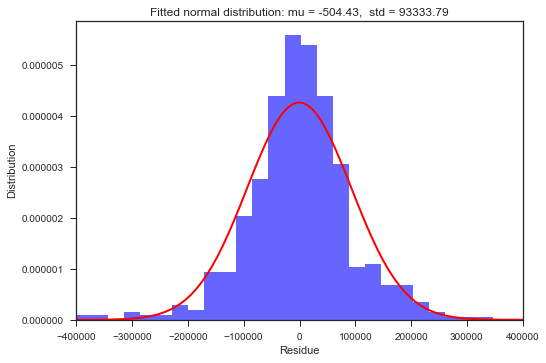

In [174]:
# Try to calculate residue and perform Normal fitting

E = y_train - grid.predict(X_train)

mask = (E>-500000) & (E<500000)
plt.hist(E[mask], bins=30, normed=True, alpha=0.6, color='b')
# Fit normal distribution to the residue data
mu, std = norm.fit(E[mask])

# Plot the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fitted normal distribution: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Residue')
plt.ylabel('Distribution')
plt.xlim(-400000,400000)

plt.show()

# residue can fit to Normal distribution, assumption of LR is valid

In [160]:
# Perform LR with 3 features, select specific Building Type and Area

X = df_temp[['Tenure','Prop_Name']].apply(le.fit_transform)
X['Size'] = df_temp['Size']
y = df_temp['Price']
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = LinearRegression()
param = {'fit_intercept' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:' ,metrics.r2_score(y_test, grid.predict(X_test)))

(939, 3) (939,)
(704, 3) (704,) (235, 3) (235,)
Score: 0.777034404144


In [161]:
# Perform LR with 4 features, select specific Building Type and Area

X = df_temp[['Tenure','Prop_Name']].apply(le.fit_transform)
X[['Size','Rooms']] = df_temp[['Size','Rooms']]
y = df_temp['Price']
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = LinearRegression()
param = {'fit_intercept' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:' ,metrics.r2_score(y_test, grid.predict(X_test)))

(939, 4) (939,)
(704, 4) (704,) (235, 4) (235,)
Score: 0.79899771661


In [163]:
# Need this for Ridge and Lasso

scale = MinMaxScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

In [164]:
# Perform Ridge with 4 features, select specific Building Type and Area

model = Ridge(max_iter=100000)
param = {'fit_intercept' : [True,False],
        'alpha' : [0.0005,0.005,0.05,0.5,5,50,500,5000]}
grid = GridSearchCV(model,param)
grid.fit(X_train_scale, y_train)
print('Score:',metrics.r2_score(y_test, grid.predict(X_test_scale)))
grid.best_params_

# not much improvement

Score: 0.79899180632


{'alpha': 0.05, 'fit_intercept': True}

In [165]:
# Perform Lasso with 4 features, select specific Building Type and Area

model = Lasso(max_iter=100000)
param = {'fit_intercept' : [True,False],
        'alpha' : [0.0005,0.005,0.05,0.5,5,50,500,5000]}
grid = GridSearchCV(model,param)
grid.fit(X_train_scale, y_train)
print('Score:',metrics.r2_score(y_test, grid.predict(X_test_scale)))
grid.best_params_

# not much improvement

Score: 0.799346305635


{'alpha': 500, 'fit_intercept': True}

In [166]:
# Perform RandomForest with 4 features, select specific Building Type and Area

model = RandomForestRegressor()
param = {'n_estimators' : [50,100,150,200,250,300],
        'bootstrap' : [True,False]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:',metrics.r2_score(y_test, grid.predict(X_test)))
grid.best_params_

# observe score can be improved further

Score: 0.909353356719


{'bootstrap': True, 'n_estimators': 250}

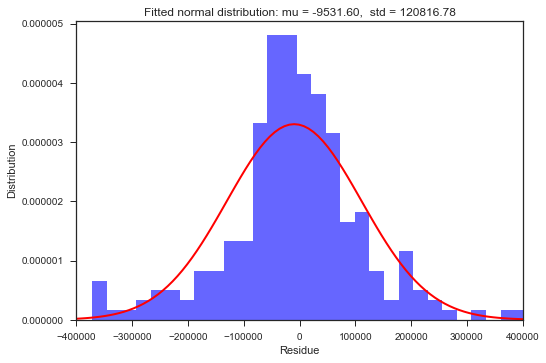

In [167]:
# Try to calculate residue and perform Normal fitting
# Based on RandomForest with 4 features, select specific Building Type and Area

E = y_test - grid.predict(X_test)

mask = (E>-500000) & (E<500000)
plt.hist(E[mask], bins=30, normed=True, alpha=0.6, color='b')
# Fit normal distribution to the residue data
mu, std = norm.fit(E[mask])

# Plot the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fitted normal distribution: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Residue')
plt.ylabel('Distribution')
plt.xlim(-400000,400000)

plt.show()

In [128]:
# Tried Neural Net, but score not as good as RandomForest

model = MLPRegressor(max_iter=5000)
param = {'hidden_layer_sizes' : [[10,10,10],[30,30,30]],
         'activation' : ['identity', 'logistic', 'tanh', 'relu'],
         'alpha' : [0.005, 0.05, 0.5]}
grid = GridSearchCV(model,param)
grid.fit(X_train, y_train)
print('Score:',metrics.r2_score(y_test, grid.predict(X_test)))
grid.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neura

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Score: 0.734941945511


{'activation': 'identity', 'alpha': 0.5, 'hidden_layer_sizes': [10, 10, 10]}

### Build individual model based on Area and Building Type

#### Construct a new DataFrame to record $5^{th}$ - $95^{th}$ percentile value for Size and Price, to remove outliers
#### In each Area and Building Type, must have >100 samples

In [175]:
C1 = []
C2 = []
C3 = []
C4 = []
C5 = []
C6 = []
C7 = []
for area in df['Area'].unique():
    mask = (df['Area']==area)
    df_temp = df[['Building Type','Size','Price']][mask]
    for btype in df_temp['Building Type'].unique():
        mask = (df_temp['Building Type']==btype)
        if (sum(mask)>100):
            C1.append(area)
            C2.append(btype)
            C3.append(sum(mask))
            C4.append(np.percentile(df_temp['Price'][mask],5))
            C5.append(np.percentile(df_temp['Price'][mask],95))
            C6.append(np.percentile(df_temp['Size'][mask],5))
            C7.append(np.percentile(df_temp['Size'][mask],95))
        
df_map = pd.DataFrame()
df_map['Area'] = C1
df_map['Building Type'] = C2
df_map['Count'] = C3
df_map['Price_5p'] = C4
df_map['Price_95p'] = C5
df_map['Size_5p'] = C6
df_map['Size_95p'] = C7
df_map.head(10)

,Area,Building Type,Count,Price_5p,Price_95p,Size_5p,Size_95p
0,desa-petaling,APARTMENT,157,150000.0,363600.0,783.800000,1010.200000
1,kl-city-centre,CONDOMINIUM,656,407500.0,3701200.0,826.250000,3767.000000
2,kl-city-centre,SERVICE RESIDENCE,1082,423640.0,3415227.5,463.000000,2848.800000
3,kl-city-centre,FLAT,120,16335.7,530400.0,392.550000,1440.450000
4,wangsa-maju,CONDOMINIUM,222,345150.0,1000000.0,904.550000,2056.000000
5,wangsa-maju,TERRACE HOUSE - INTERMEDIATE,157,299600.0,822000.0,616.166916,1541.219011
6,wangsa-maju,FLAT,315,113500.0,250000.0,527.000000,710.000000
7,wangsa-maju,APARTMENT,115,248500.0,487500.0,592.000000,1227.000000
8,jinjang,FLAT,133,60000.0,215000.0,549.000000,813.400000
9,seputeh,SERVICE RESIDENCE,123,410000.0,718500.0,578.000000,1208.700000


In [177]:
print('df_map.shape: ',df_map.shape)
print('Unique Area count:',df_map['Area'].nunique())
df_map['Building Type'].value_counts()

df_map.shape:  (59, 7)
Unique Area count: 29


CONDOMINIUM                     19
TERRACE HOUSE - INTERMEDIATE    11
APARTMENT                       10
FLAT                            10
SERVICE RESIDENCE                9
Name: Building Type, dtype: int64

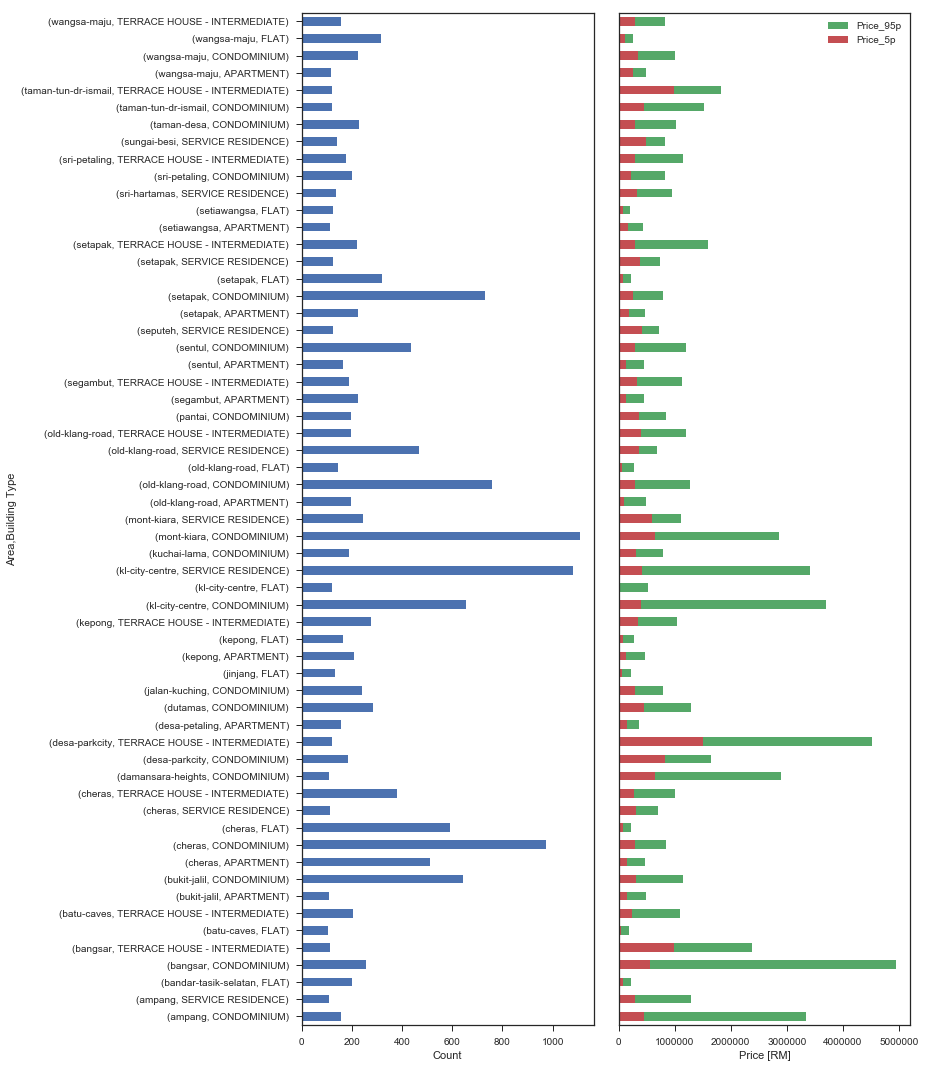

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,15))

df_grp = df_map.groupby(['Area','Building Type'])['Count'].sum()
df_grp.plot(kind='barh', ax = axes[0])
axes[0].set_xlabel('Count')

df_grp = df_map.groupby(['Area','Building Type'])['Price_95p'].sum()
df_grp.plot(kind="barh", color='C1', legend=True, use_index=False, ax = axes[1])
df_grp = df_map.groupby(['Area','Building Type'])['Price_5p'].sum()
df_grp.plot(kind="barh", color='C2', legend=True, use_index=False, ax = axes[1])
axes[1].set_yticks([])
axes[1].set_xlabel('Price [RM]')

plt.tight_layout()

In [179]:
# Insert into df_map['Score1'] the individual model score of Linear Regression, 1 feature (Size)

C1 = []
for row in np.arange(df_map.shape[0]):
    mask = (df['Area']==df_map['Area'].iloc[row]) & (df['Building Type']==df_map['Building Type'].iloc[row])
    df_temp = df[mask]
    mask = (df_temp['Price']>df_map['Price_5p'].iloc[row]) & (df_temp['Price']<df_map['Price_95p'].iloc[row])
    df_temp = df_temp[mask]
    mask = (df_temp['Size']>df_map['Size_5p'].iloc[row]) & (df_temp['Size']<df_map['Size_95p'].iloc[row])
    df_temp = df_temp[mask]

    x = df_temp['Size']
    y = df_temp['Price']
    X = x[:, np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    model = LinearRegression()
    param = {'fit_intercept' : [True,False]}
    grid = GridSearchCV(model,param)
    grid.fit(X_train, y_train)
    C1.append(metrics.r2_score(y_test, grid.predict(X_test)))

df_map['Score1'] = C1  # Size

In [184]:
# Insert into df_map['Score2'] the individual model score of Linear Regression, 3 features (Size, Tenure, Prop_Name)

C1 = []
for row in np.arange(df_map.shape[0]):
    mask = (df['Area']==df_map['Area'].iloc[row]) & (df['Building Type']==df_map['Building Type'].iloc[row])
    df_temp = df[mask]
    mask = (df_temp['Price']>df_map['Price_5p'].iloc[row]) & (df_temp['Price']<df_map['Price_95p'].iloc[row])
    df_temp = df_temp[mask]
    mask = (df_temp['Size']>df_map['Size_5p'].iloc[row]) & (df_temp['Size']<df_map['Size_95p'].iloc[row])
    df_temp = df_temp[mask]
    
    X = df_temp[['Tenure','Prop_Name']].apply(le.fit_transform)
    X['Size'] = df_temp['Size']
    y = df_temp['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    model = LinearRegression()
    param = {'fit_intercept' : [True,False]}
    grid = GridSearchCV(model,param)
    grid.fit(X_train, y_train)
    C1.append(metrics.r2_score(y_test, grid.predict(X_test)))
    
df_map['Score2'] = C1  # Size, Tenure, Prop_Name

In [180]:
# 4 features (Size, Tenure, Prop_Name, Rooms)
# Insert into df_map['Score3'] the individual model score of Linear Regression
# Insert into df_map['Score4'] the individual model score of Ridge Regression
# Insert into df_map['Score5'] the individual model score of Lasso Regression
# Insert into df_map['Score6'] the individual model score of RandomForest Regressor

C1 = []
C2 = []
C3 = []
C4 = []
for row in np.arange(df_map.shape[0]):
    mask = (df['Area']==df_map['Area'].iloc[row]) & (df['Building Type']==df_map['Building Type'].iloc[row])
    df_temp = df[mask]
    mask = (df_temp['Price']>df_map['Price_5p'].iloc[row]) & (df_temp['Price']<df_map['Price_95p'].iloc[row])
    df_temp = df_temp[mask]
    mask = (df_temp['Size']>df_map['Size_5p'].iloc[row]) & (df_temp['Size']<df_map['Size_95p'].iloc[row])
    df_temp = df_temp[mask]
    
    X = df_temp[['Tenure','Prop_Name']].apply(le.fit_transform)
    X[['Size','Rooms']] = df_temp[['Size','Rooms']]
    y = df_temp['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    model = LinearRegression()
    param = {'fit_intercept' : [True,False]}
    grid = GridSearchCV(model,param)
    grid.fit(X_train, y_train)
    C1.append(metrics.r2_score(y_test, grid.predict(X_test)))
    
    scale = MinMaxScaler()
    X_train_scale = scale.fit_transform(X_train)
    X_test_scale = scale.transform(X_test)
    
    model = Ridge(max_iter=10000)
    param = {'fit_intercept' : [True,False],
            'alpha' : [0.00005,0.0005,0.005,0.05,0.5,5,50,500,5000,50000]}
    grid = GridSearchCV(model,param)
    grid.fit(X_train_scale, y_train)
    C2.append(metrics.r2_score(y_test, grid.predict(X_test_scale)))
    
    model = Lasso(max_iter=10000)
    param = {'fit_intercept' : [True,False],
            'alpha' : [0.00005,0.0005,0.005,0.05,0.5,5,50,500,5000,50000]}
    grid = GridSearchCV(model,param)
    grid.fit(X_train_scale, y_train)
    C3.append(metrics.r2_score(y_test, grid.predict(X_test_scale)))
    
    model = RandomForestRegressor()
    param = {'n_estimators' : [50,100,150,200,250,300],
            'bootstrap' : [True,False]}
    grid = GridSearchCV(model,param)
    grid.fit(X_train, y_train)
    C4.append(metrics.r2_score(y_test, grid.predict(X_test))) 

df_map['Score3'] = C1  # LR
df_map['Score4'] = C2  # Ridge with scaling
df_map['Score5'] = C3  # Lasso with scaling
df_map['Score6'] = C4  # RandomForest 

In [185]:
df_map.head()

,Area,Building Type,Count,Price_5p,Price_95p,Size_5p,Size_95p,Score1,Score3,Score4,Score5,Score6,Score2
0,desa-petaling,APARTMENT,157,150000.0,363600.0,783.80,1010.20,0.320611,0.408853,0.402851,0.394868,0.543515,0.380691
1,kl-city-centre,CONDOMINIUM,656,407500.0,3701200.0,826.25,3767.00,0.750088,0.771868,0.772400,0.771868,0.859481,0.769473
2,kl-city-centre,SERVICE RESIDENCE,1082,423640.0,3415227.5,463.00,2848.80,0.785622,0.786879,0.784911,0.787092,0.927353,0.787420
3,kl-city-centre,FLAT,120,16335.7,530400.0,392.55,1440.45,0.514375,0.460084,0.452323,0.482456,0.462252,0.417646
4,wangsa-maju,CONDOMINIUM,222,345150.0,1000000.0,904.55,2056.00,0.578282,0.567131,0.568668,0.587217,0.504478,0.554366


In [83]:
#mask = df['Area'].isin(df_map['Area']) & df['Building Type'].isin(df_map['Building Type'])

df_map.shape (score >0.5):  (43, 13)
Unique Area count (score >0.5): 25


CONDOMINIUM                     19
TERRACE HOUSE - INTERMEDIATE    11
APARTMENT                       10
FLAT                            10
SERVICE RESIDENCE                9
Name: Building Type, dtype: int64

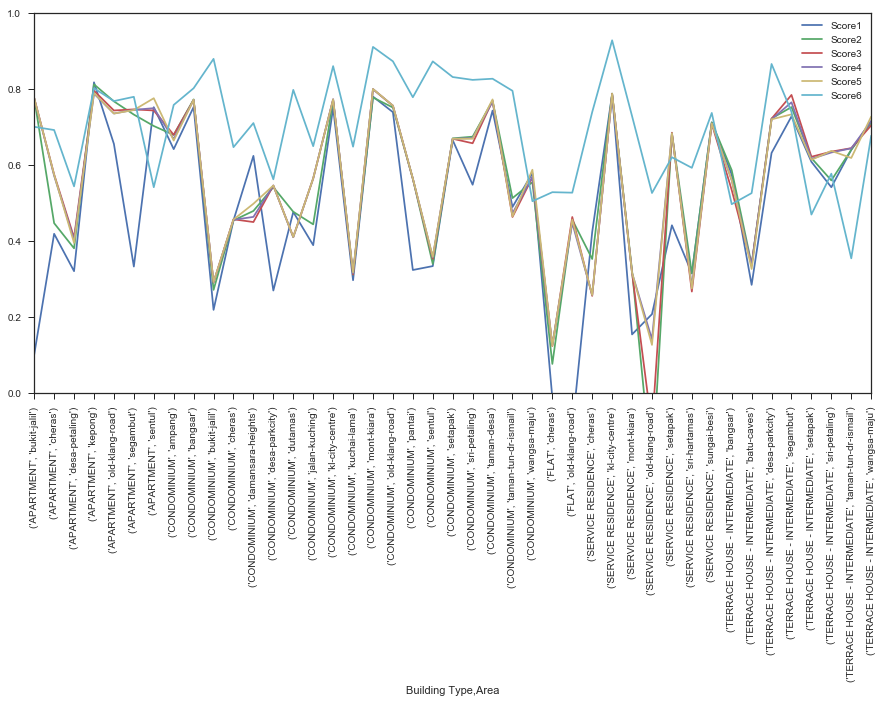

In [189]:
# Only plot Scores with >0.5 performance

mask = (((df_map['Score1']>0.5) | (df_map['Score2']>0.5)) | (df_map['Score3']>0.5)) | (df_map['Score4']>0.5)
mask = (mask & (df_map['Score5']>0.5)) | (df_map['Score6']>0.5)

df_grp = df_map[mask].groupby(['Building Type','Area'])[['Score1','Score2','Score3',
                                                         'Score4','Score5','Score6']].sum()
ax = df_grp.plot(ylim=(0,1), figsize=(15,7))
ax.set_xticks(np.arange(sum(mask)))
ax.set_xticklabels(df_grp.index,rotation=90);

print('df_map.shape (score >0.5): ',df_map[mask].shape)
print('Unique Area count (score >0.5):',df_map['Area'][mask].nunique())
df_map['Building Type'].value_counts()

# Can observe generally RandomForest is best model

# Score1: LR with 1 feature (Size)
# Score2: LR with 3 features (Size, Tenure, Prop_Name)
# Score3: LR with 4 features (Size, Tenure, Prop_Name, Rooms)
# Score4: Ridge with 4 features (Size, Tenure, Prop_Name, Rooms)
# Score5: Lasso with 4 features (Size, Tenure, Prop_Name, Rooms)
# Score6: RandomForest with 4 features (Size, Tenure, Prop_Name, Rooms)

In [187]:
df_temp = df_map[['Area','Building Type']][~mask]

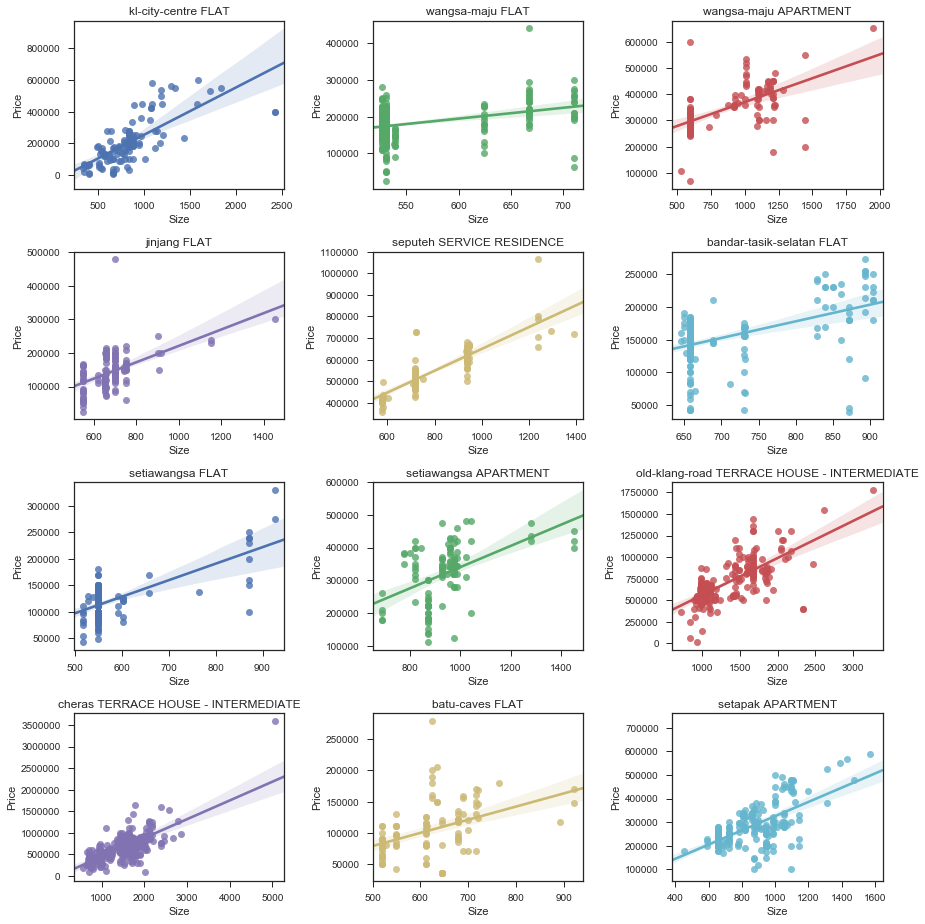

In [188]:
# Price-Size scatter plot for model with score <0.5

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(13,13))
count = 0
for row in axes:
    for col in row:
        mask = (df['Area']==df_temp['Area'].iloc[count]) & (df['Building Type']==df_temp['Building Type'].iloc[count])
        sns.regplot(y="Price", x="Size", data=df[mask], ax=col)
        col.set_title(df_temp['Area'].iloc[count] + ' ' + df_temp['Building Type'].iloc[count])
        count = count+1
plt.tight_layout()

# Points scattered to large degree, challenging to be fitted in linear line
# Prediction has large residue errors, both under- and over-estimated

## Conclusions

Although dataset is small with less features (6), price may still be predicted using linear models.
RandomForest appeared to perform well, Linear Regression served as baseline. 

#### To improve prediction performance:
* Build individual model for specific Area & Building Type
* Remove outliers by using data with Price & Size within $5^{th}$ - $95^{th}$ percentile range
* Use all features in training

#### Limitations:
* Weakness in modelling data with non common Building Type, e.g. Bangalow and Semi-D due to their diverse price range
* Insufficient samples to model other Building Type, e.g. Terrace - End, Terrace - Corner, Cluster House

#### Data Enrichments:
* Property conditions (e.g. Reno)
* Neighbourhood condition
* Surrounding infrastructure
* Security 
* Access
* Year of build
* Distance from certain landmark

In [ ]:
jupyter nbconvert Jupyter\ EDS_Assignment_20180316.ipynb --to slides --post serve